In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.vgg16 import VGG16, preprocess_input

## Pretrained Model

In [ ]:
asd = VGG16(weights="imagenet", input_shape=(150, 150, 3), include_top=False, pooling="avg")
asd.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

## Autoencoder

In [ ]:
import keras
from keras import layers

input_img = keras.Input(shape=(150, 150, 3))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (19, 19, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.ZeroPadding2D(padding=(1, 1))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

## Custom Loss Function

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
def custom_loss(y_true, y_pred):
    y_true_pre = preprocess_input(y_true*255)
    y_pred_pre = preprocess_input(y_pred*255)
    
    y_true_perc = asd(y_true_pre)
    y_pred_perc = asd(y_pred_pre)
    
    return mse(y_true, y_pred) + 0.1*mse(y_true_perc, y_pred_perc)

In [ ]:
images = tfds.load(name="colorectal_histology", split="train", as_supervised=True)
images = images.batch(16)
images = images.map(lambda img,lab: (tf.image.convert_image_dtype(img, dtype=tf.float32),lab))
images = images.map(lambda img,lab: (img,img))

Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteQKYDIP/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


## Train

In [ ]:
autoencoder.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 8)         0     

In [ ]:
autoencoder.fit(images,
                epochs=10,
                batch_size=128,
                shuffle=True,)

Epoch 1/10
313/313 [==============================] - 90s 126ms/step - loss: 1.6187 - accuracy: 0.5180
Epoch 2/10
313/313 [==============================] - 38s 122ms/step - loss: 1.1129 - accuracy: 0.6827
Epoch 3/10
313/313 [==============================] - 40s 126ms/step - loss: 1.0308 - accuracy: 0.6860
Epoch 4/10
313/313 [==============================] - 42s 133ms/step - loss: 0.9790 - accuracy: 0.6875
Epoch 5/10
313/313 [==============================] - 40s 129ms/step - loss: 0.9430 - accuracy: 0.6901
Epoch 6/10
313/313 [==============================] - 41s 131ms/step - loss: 0.9047 - accuracy: 0.6918
Epoch 7/10
313/313 [==============================] - 40s 127ms/step - loss: 0.8824 - accuracy: 0.6923
Epoch 8/10
313/313 [==============================] - 40s 127ms/step - loss: 0.8724 - accuracy: 0.6929
Epoch 9/10
313/313 [==============================] - 41s 130ms/step - loss: 0.8519 - accuracy: 0.6926
Epoch 10/10
313/313 [==============================] - 41s 130ms/step - l

In [ ]:
import matplotlib.pyplot as plt

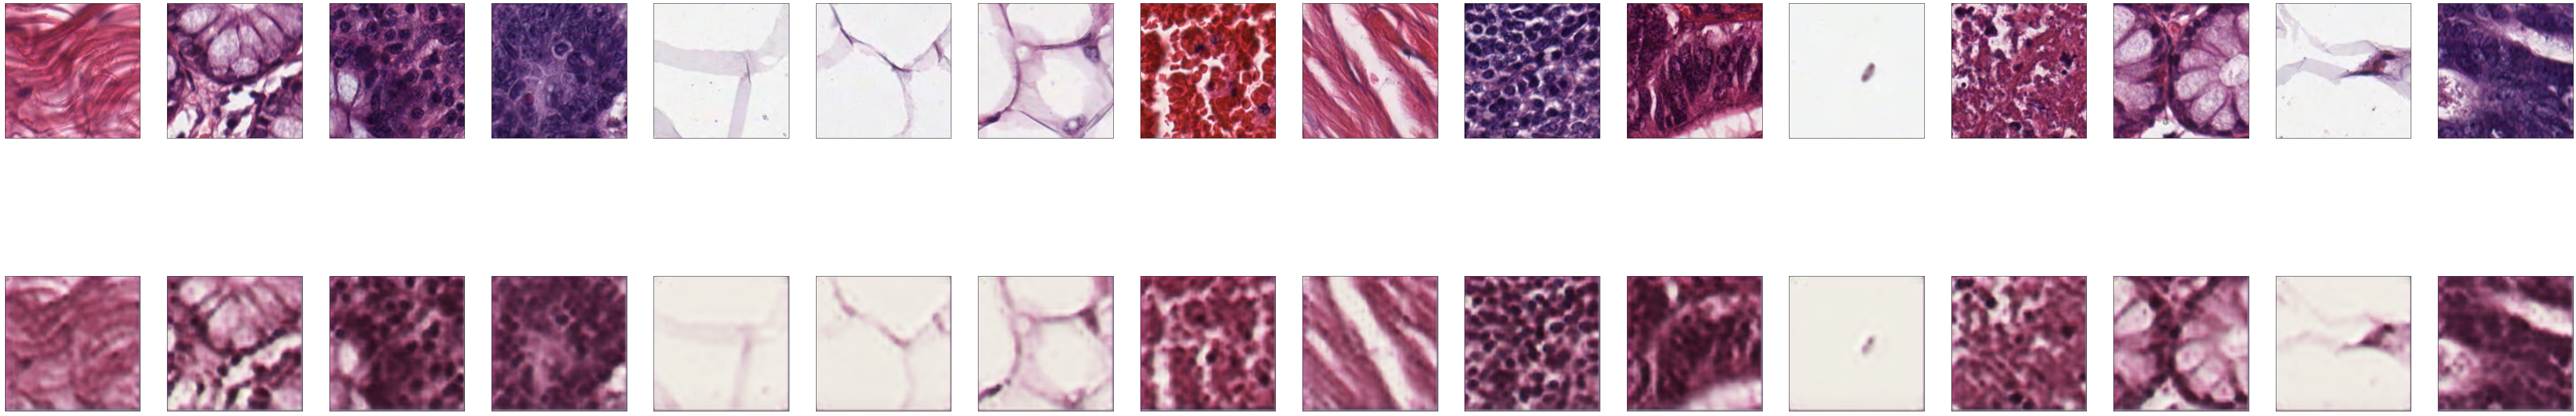

In [ ]:
# decoded_imgs = autoencoder.predict(images)
n = 16
plt.figure(figsize=(100, 20))
i = 1

for img_b, label_b in images.take(1):     
    decoded_img = autoencoder.predict(img_b)
    
    for i in range(decoded_img.shape[0]):
        j = i + 1
        
        # Display original
        ax = plt.subplot(2, n, j)
        plt.imshow(img_b[i,:,:,:])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, j + n)
        plt.imshow(decoded_img[i,:,:,:])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()